Hello, Index here!!

0. Configuration of environment : Gym--FrozenLake Slippery or NotSlippery--
1. Policy Iteration
2. Value Iteration
3. Experiment 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

%matplotlib inline

0. Configuration of environment : Gym--FrozenLake Slippery or NotSlippery

In [3]:
gym.envs.register(
id="FrozenLakeNotSlippery-v0",
entry_point="gym.envs.toy_text:FrozenLakeEnv",
kwargs={'map_name':'4x4', "is_slippery":False},
max_episode_steps=100,)
gym.envs.register(
id="FrozenLakeSlippery-v0",
entry_point="gym.envs.toy_text:FrozenLakeEnv",
kwargs={'map_name':'4x4', "is_slippery":True},
max_episode_steps=100,)

1&2. Policy Iteration & Value Iteration

In [4]:
class DP:
    
    def __init__(self,theta= 0.0001, discount_factor=1, dynamic="stochastic", mode="policy_iteration"):
        # ----------------------------------parameter-----------------------------#
        self.theta = theta
        self.discount_factor = discount_factor
        self.dynamic = dynamic
        self.mode = mode
        self.delta = 0
        
        self.state_size = 16
        self.action_size = 4
        
        
        mode_args = ['policy_iteration', 'value_iteration', 'GPI']
        if self.mode not in mode_args:
            raise RuntimeError('mode may be wrong. you should choose one of them,"policy_iteration", "value_iteration" and "GPI"')
        # -----------------------------------env-----------------------------------#
        
        if self.dynamic == "stochastic":
            self.env = gym.make("FrozenLakeSlippery-v0")
        elif self.dynamic == "deterministic":
            self.env = gym.make("FrozenLakeNotSlippery-v0")
        else:
            raise RuntimeError("dynamic may be wrong!!")
        
        # -------------------------------value fucntion-----------------------------#
        
        self.state_value = {}
        self.action_value = {}
        
    
    def get_action(self,state):
        """
        input : state [int]
        output : action, []
                 probability of action, float
        
        if elements of q_values are same each other, then the best action can be various even if the policy is greedy method.
        so we must take account into the action probability.
        if the number of candidate action is larger than 1, then the action probability must be divided the number.
        
        """
        q_value = self.action_value[state]
        maximum = np.max(q_value)
        action = np.where(q_value==maximum)[0]
        prob_a = 1/len(action)
        
        return action, prob_a
        
        
    def initialize(self):
        for i in range(self.state_size):
            self.state_value[i] = 0
            self.action_value[i] = np.zeros(self.action_size)
        
    def reset_state(self):
        """
        if mode is value iteration, this method can not be invoked.
        """
        for i in range(self.state_size):
            self.state_value[i] = 0
    def print_status(self):
        V = np.zeros(self.state_size)
        for i in range(self.state_size):
            V[i] = self.state_value[i]
        
        sns.heatmap(V.reshape(4,4), annot=True,cbar=False)
    def policy_evalution(self):
        """
        policy evaluation is the process which is performed in both value iteration and policy iteration.
        The only difference is whether to converge or not when this method is invoked.
        of course, both algorithm leads to convergence of state value in the end. In local evalution, however, only policy iteration
        gets convergence of state value.
        """
        while(1):
            prev_state = self.state_value.copy()
            delta = 0
            for state in range(self.state_size):
                prev_state[state] = self.state_value[state]
                prime_sv = 0
                action, prob_a = self.get_action(state)
                for act in action:
                    po_obs = self.env.P[state][act] # ([], [], ...)
                    for ob in po_obs:
                        prob, next_state, reward, done = ob
                        if done:
                            prime_sv += prob *prob_a * reward
                        else:
                            prime_sv += prob *prob_a * (reward + self.discount_factor * prev_state[next_state])
                
                self.state_value[state] = prime_sv
                delta_temp = abs(prime_sv - prev_state[state])
            
                if (delta_temp > delta):
                    delta = delta_temp
                    self.delta = delta
            if ( delta < self.theta)or(self.mode == 'value_iteration'):
                break
    def policy_update(self):
        """
        In greedy method, the policy can be viewed as state-action value. by using this method, update the q_value based on state value.
        """
        self.prev_action_value ={}
        for state in range(self.state_size):
            self.prev_action_value[state] = self.action_value[state].copy()
            for action in range(self.action_size):
                po_obs = self.env.P[state][action]
                q_value = 0
                for ob in po_obs:
                    prob, next_state, reward, done = ob
                    if done:
                        q_value += prob * reward
                    else:
                        q_value += prob * (reward + self.discount_factor * self.state_value[next_state])
                
                self.action_value[state][action] = q_value
    
    def check_convergence(self):
        
        converge = True 
        for state in range(self.state_size):
            maximum = np.max(self.prev_action_value[state])
            prev_action = np.where(self.prev_action_value[state]==maximum)[0].tolist()
            
            maximum = np.max(self.action_value[state])
            action = np.where(self.action_value[state]==maximum)[0].tolist()
            
            
            converge = action == prev_action
            if converge == False:

                return converge
        
        return converge
            
    
    def run(self):
        self.initialize()
        while(1):
            self.policy_evalution()
            self.policy_update()
            if self.check_convergence() and (self.mode =="policy_iteration"):
                break
                
            if (self.mode =="policy_iteration"):
                self.reset_state() # it must be inited because the policy which would be evaluated is changed.
            
            if (self.mode == "value_iteration") and (self.delta < self.theta):
                break
            
        
        self.print_status()

arguments

    1.theta : the precision of evluation, default:0.0001
    
    2.discount_factor: default:1
    
    3.dynamic:"deterministic" or "stochastic", default:"stochastic"
    
    4.mode:"policy_iteration" or "value_iteration", default:"policy_iteration"
    

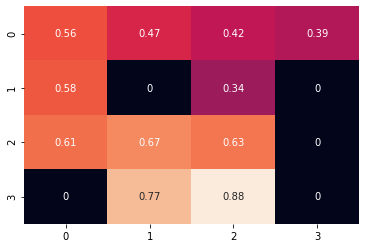

In [5]:
policy_iteration = DP(theta=0.01)
policy_iteration.run()

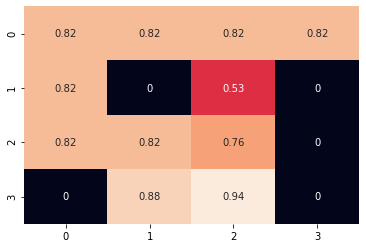

In [6]:
value_iteration = DP(theta=0.0001,mode="value_iteration")
value_iteration.run()

both alogorithms lead to the different state value function.

3.Experiment

1. Deterministic vs Stochastic
    - all states except terminal states have the same value 1 in the deterministic environment. if policy is optimal, regardless of the state, they will reach the goal. and then, they get goal reward. but in the stochastic environment, even though policy is optimal, the agent can not reach the goal.

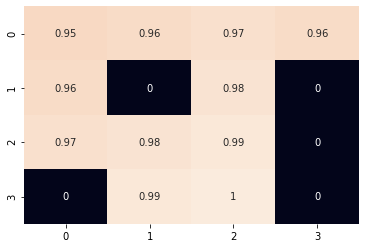

In [7]:
det_case = DP(dynamic="deterministic",discount_factor=0.99)
det_case.run()

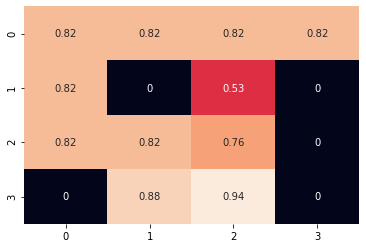

In [8]:
det_case = DP(dynamic="stochastic")
det_case.run()

2. low theta vs high theta :policy iteration
    - theta means that the precision of policy evaluation. if theta is high, the total calucation of policy evaluation may be increased but lead to robustness of training. here is my experiment
    1. theta = 0.1
    2. theta = 0.01
    3. theta = 0.0001

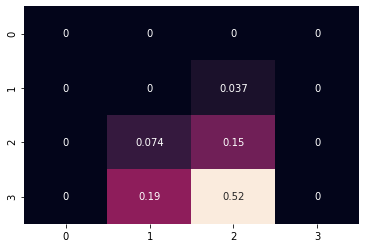

In [9]:
low_theta = DP(theta=0.1)
low_theta.run()

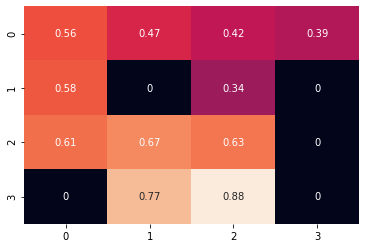

In [10]:
mid_theta = DP(theta=0.01)
mid_theta.run()

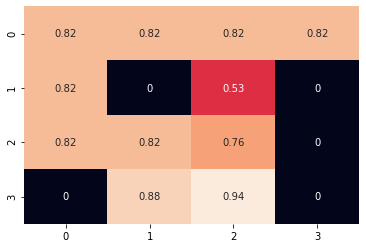

In [11]:
high_theta = DP(theta=0.0001)
high_theta.run()

This result shows that if theta is too low, then the training can be unstable.

3. fluctuation
    - you can already notice that in experiment 1, I set the discount factor 0.99 if the dynamic is deterministic. Actually, optimal policy is a collection of optimal policy set. In my code, policy is fluctuating between two optimal policy set, A, B. but  B belongs to A. so this flucutation can no be solved. To prevent this fluctuation, I set the discount factor 0.99, and this leads to the policy converge to A which include policy B.